In [82]:
# Imports
from osgeo import gdal, gdal_array

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import glob
from PIL import Image
import cv2
import numpy as np


# Example usage
input_tiff = './LandInsidePolygon.tif'  # Path to your input TIFF file
output_tiff = './Desat_Still_Air.tif'  # Path for the output TIFF file
saturation_scale = 0.5  # Reduce saturation to 50% (adjust as needed)

def adjust_saturation(input_path, output_path, saturation_scale):
    # Open the source image
    dataset = gdal.Open(input_path)
    if dataset is None:
        raise Exception("Could not open image")

    # Read the RGB bands
    band_r = dataset.GetRasterBand(1).ReadAsArray()
    band_g = dataset.GetRasterBand(2).ReadAsArray()
    band_b = dataset.GetRasterBand(3).ReadAsArray()

    # Convert the bands to float and scale to [0,1]
    band_r = band_r / 65535.0
    band_g = band_g / 65535.0
    band_b = band_b / 65535.0

    # Convert to HSV, adjust saturation, and convert back to RGB
    rgb = np.stack((band_r, band_g, band_b), axis=-1)
    hsv = colors.rgb_to_hsv(rgb)
    hsv[..., 1] *= saturation_scale
    rgb_adjusted = colors.hsv_to_rgb(hsv)

    # Convert to NumPy data type
    np_dtype = gdal_array.GDALTypeCodeToNumericTypeCode(dataset.GetRasterBand(1).DataType)

    # Now use np_dtype with astype
    band_r = (rgb_adjusted[..., 0] * 65535).astype(np_dtype)
    band_g = (rgb_adjusted[..., 1] * 65535).astype(np_dtype)
    band_b = (rgb_adjusted[..., 2] * 65535).astype(np_dtype)
    # Write each band back to the output image
    driver = gdal.GetDriverByName('GTiff')
    out_dataset = driver.Create(output_path, dataset.RasterXSize, dataset.RasterYSize, 3, dataset.GetRasterBand(1).DataType)
    out_dataset.SetGeoTransform(dataset.GetGeoTransform())
    out_dataset.SetProjection(dataset.GetProjection())
    out_dataset.GetRasterBand(1).WriteArray(band_r)
    out_dataset.GetRasterBand(2).WriteArray(band_g)
    out_dataset.GetRasterBand(3).WriteArray(band_b)

    # Clean up
    out_dataset = None
    dataset = None

adjust_saturation(input_tiff, output_tiff,saturation_scale)


(16, 2571, 1719)
351 8327


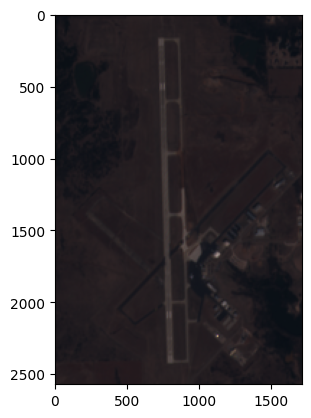

In [83]:

#Load first image
Filename='LandInsidePolygon.tif'
img = gdal.Open(Filename).ReadAsArray()
print(img.shape) #(12,256,256)

rgb = img[[3,2,1]].transpose(1,2,0)
print(rgb.min(),rgb.max()) #150 8,600
rgb = np.clip(rgb/10000,0,1)
plt.imshow(rgb)





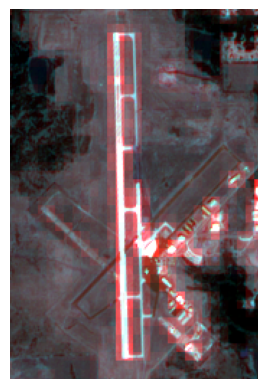

In [84]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

# Load the image using GDAL
dataset = gdal.Open('./LandInsidePolygon.tif')

# Check if the dataset is valid
if not dataset:
    raise FileNotFoundError("Dataset not found or GDAL could not open the file.")

# Read the first three bands (assuming these are RGB)
bands = []
for i in range(1, 4):  # GDAL uses 1-based indexing for bands
    band = dataset.GetRasterBand(i).ReadAsArray()
    bands.append(band)

# Stack the bands to create an RGB image
rgb_image = np.dstack(bands)

# Normalize the image to 0-255 and convert to uint8
rgb_normalized = np.zeros_like(rgb_image)
for i in range(3):
    band_min, band_max = np.percentile(rgb_image[:, :, i], (2, 98))
    rgb_normalized[:, :, i] = np.clip(255 * (rgb_image[:, :, i] - band_min) / (band_max - band_min), 0, 255).astype(np.uint8)

# Display the image using matplotlib
plt.imshow(rgb_normalized)
plt.axis('off')
plt.show()



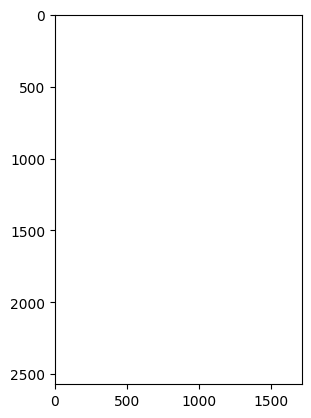

In [85]:

dataset = gdal.Open(output_tiff)
band1 = dataset.GetRasterBand(1).ReadAsArray()
band2 = dataset.GetRasterBand(2).ReadAsArray()
band3 = dataset.GetRasterBand(3).ReadAsArray()

# Stack bands for RGB
rgb_array = np.stack((band1, band2, band3), axis=2)

# Clip the values to the 0-255 range and make sure it's uint8 for proper display
rgb_clipped = np.clip(rgb_array, 0, 255).astype(np.uint8)

# Visualize the RGB composite
plt.imshow(rgb_clipped)
plt.show()

In [86]:
def visualise_rgb(img,clip=[0.3,0.3,0.3],display=True):
        """Visulaise RGB image with given clip values and return image"""

        # Scale image
        img = np.clip(img/10000,0,1)
        
        # Get RGB channels
        rgb = img[[3,2,1]]

        #clip rgb values
        rgb[0] = np.clip(rgb[0],0,clip[0])/clip[0]
        rgb[1] = np.clip(rgb[1],0,clip[1])/clip[1]
        rgb[2] = np.clip(rgb[2],0,clip[2])/clip[2]

        rgb = rgb.transpose(1,2,0)

        if display:

                #Display histograms of pixel intesity with given clip values
                fig, axs = plt.subplots(1,4,figsize=(22,5))
                fig.patch.set_facecolor('xkcd:white')

                labels = ['Red','Green','Blue']
                for i,ax in enumerate(axs[0:3]):
                        ax.hist(img[3-i].flatten(),bins=100)
                        ax.set_title(labels[i],size=20,fontweight="bold")
                        ax.axvline(clip[i],color="red",linestyle="--")
                        ax.set_yticks([])

                #Display RGB image
                axs[3].imshow(rgb)
                axs[3].set_title("RGB",size=20,fontweight="bold")
                axs[3].set_xticks([])
                axs[3].set_yticks([])

        return rgb

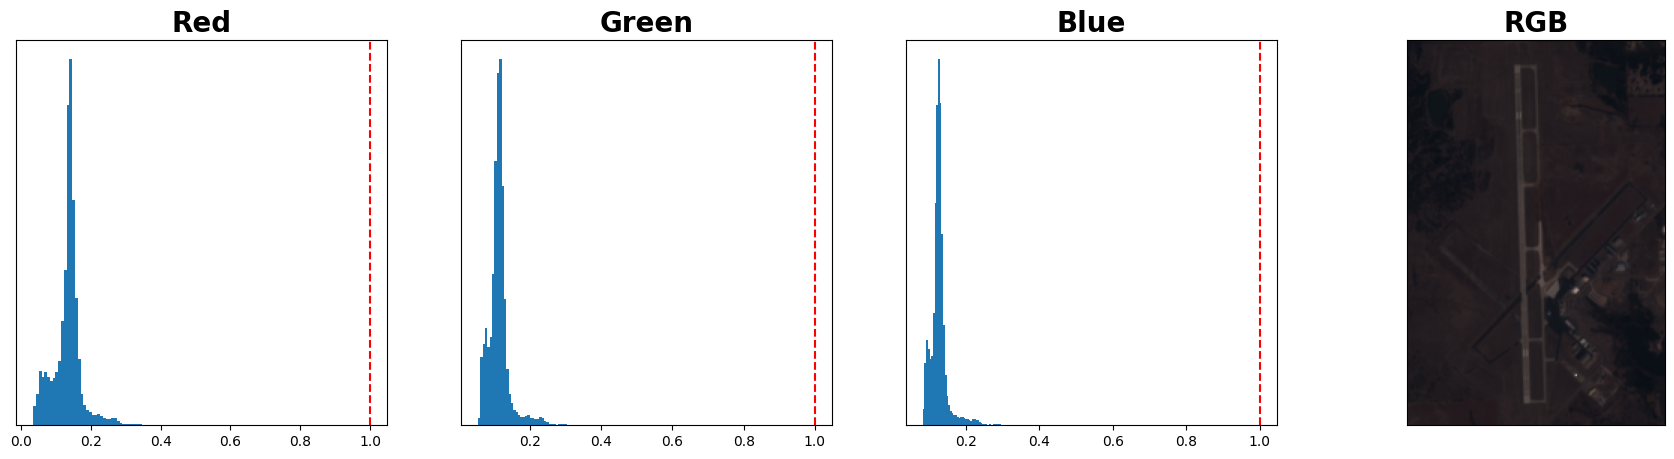

In [87]:
img = gdal.Open(Filename).ReadAsArray()
rgb = visualise_rgb(img,[1,1,1])

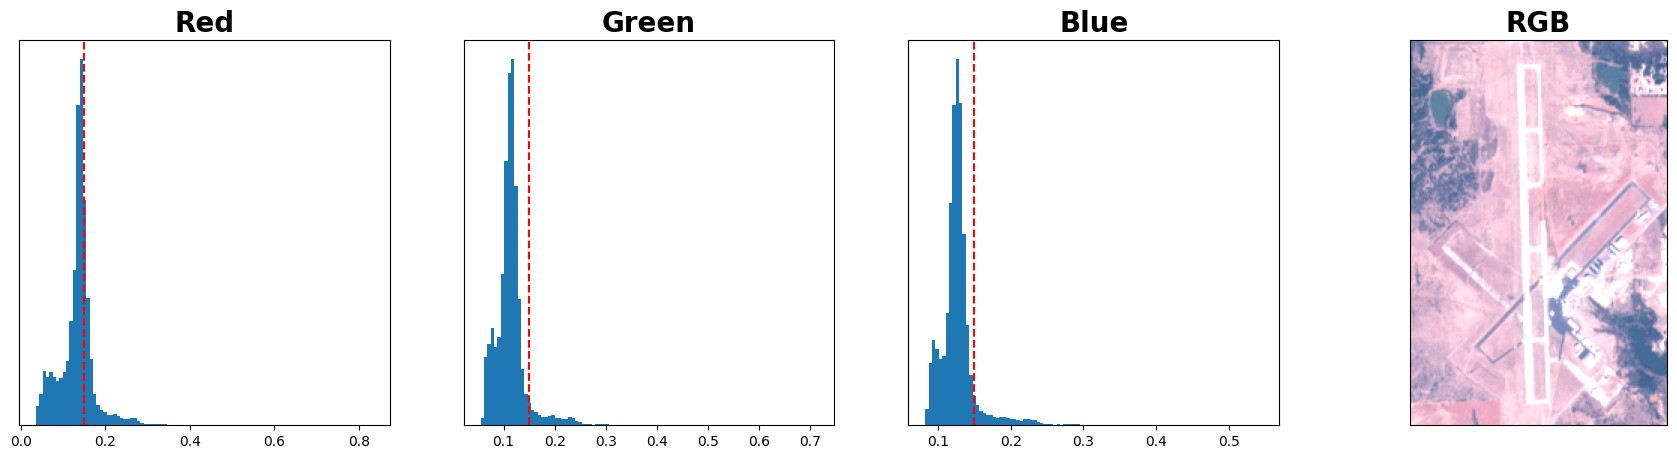

In [88]:
rgb_1 = visualise_rgb(img,[0.15,0.15,0.15],display=True )


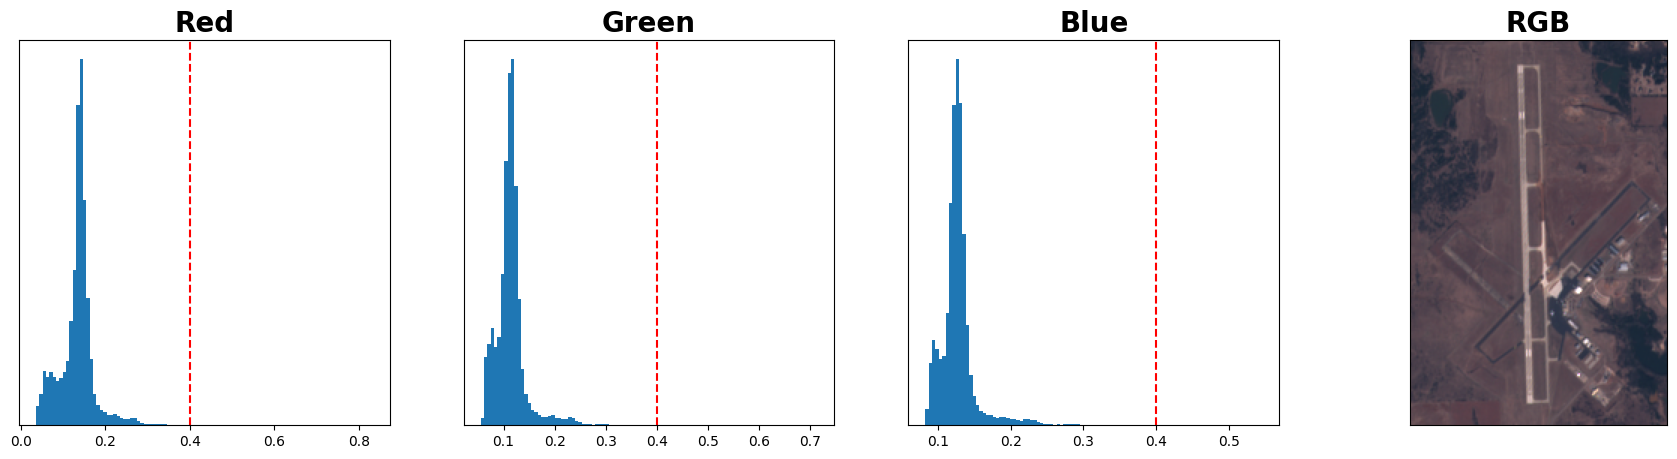

In [89]:

rgb_2 = visualise_rgb(img,[0.4,0.4,0.4],display=True )


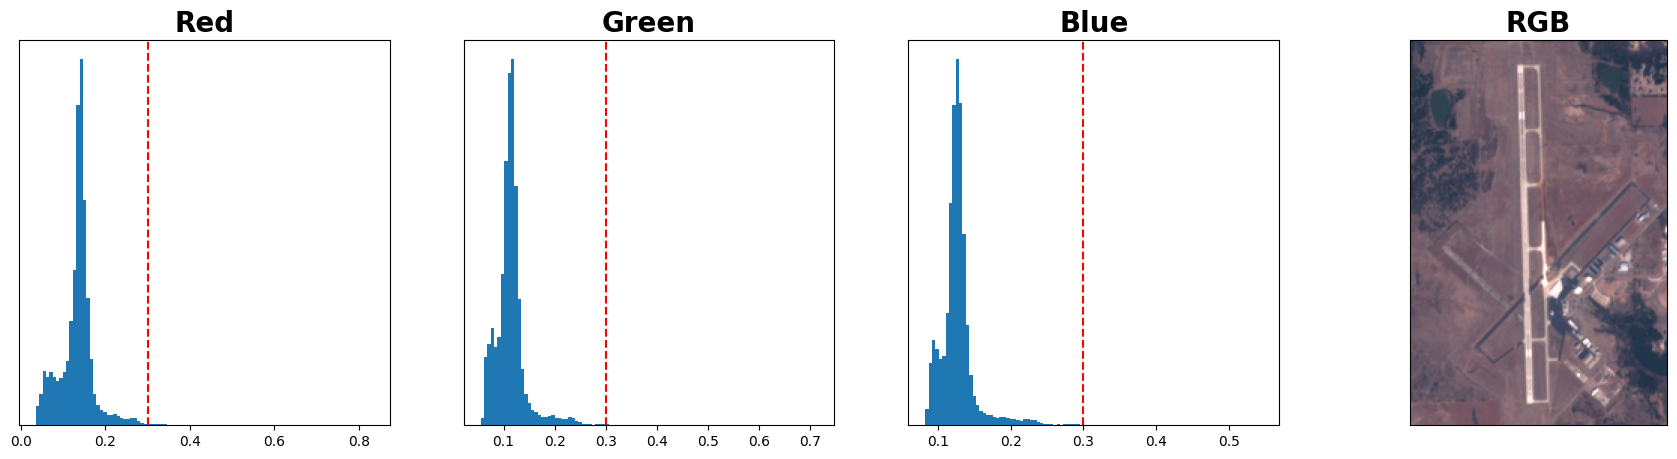

In [90]:

rgb_3 = visualise_rgb(img,[0.3,0.3,0.3],display=True )